In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib
from matplotlib import pyplot as plt

In [2]:
if matplotlib.__version__ < "3.7":
    %pip install matplotlib==3.7

In [20]:
sns.set_theme(style='white')

In [4]:
os.listdir('./data')

['gadget_youtube_2023-10-10.parquet',
 'gadget_youtube_2023-09-27.parquet',
 'gadget_youtub_2023-10-02.parquet',
 'gadget_youtube_2023-10-03.parquet',
 'gadget_shopee_2023-09-29.parquet',
 'gadget_youtub_2023-10-06.parquet',
 'gadget_shopee_2023-10-03.parquet',
 '.ipynb_checkpoints',
 'gadget_shopee_2023-10-10.parquet']

# Youtube

In [5]:
# load data
df_ytb_raw = None
files = [x for x in os.listdir('./data') if 'youtube'in x]
for file in files:
    df_i = pd.read_parquet(f'./data/{file}')
    df_ytb_raw = pd.concat([df_ytb_raw,df_i])
# date
df_ytb_raw['date'] = df_ytb_raw['time_scrapped'].dt.date
# views
df_ytb_raw['views_str'] = df_ytb_raw['views']
df_ytb_raw['views_split'] = df_ytb_raw['views_str'].str.split(' ').apply(lambda x: x[1:-1] + [''])
df_ytb_raw['views_digit'] = df_ytb_raw['views_split'].apply(lambda x:x[0])
df_ytb_raw['mutiplier_str'] = df_ytb_raw['views_split'].apply(lambda x:x[1])
multiplier = pd.DataFrame({'mutiplier_str':['พัน', '', 'หมื่น', 'แสน','ล้าน'],
                           'mutiplier':[10**3,1,10**4,10**5,10**6]})
df_ytb_raw = df_ytb_raw.merge(multiplier, on='mutiplier_str', how='left').fillna(1)
df_ytb_raw['views'] = pd.to_numeric(df_ytb_raw['views_digit'])*df_ytb_raw['mutiplier']
df_ytb_raw = df_ytb_raw.drop(['views_split','views_digit','mutiplier_str','mutiplier','views_str'],1)
# de-duplicate
df_ytb_raw['rank'] = df_ytb_raw.groupby(['channel','video_title','date'])['views'].rank(ascending=False, method='first')
df_ytb_raw = df_ytb_raw[df_ytb_raw['rank']==1].drop('rank', 1)
# daily views
index = ['channel','video_title']
df_ytb_raw = df_ytb_raw.sort_values([*index,'date'])
df_ytb_raw['views_lag'] = df_ytb_raw.groupby(index)['views'].shift()
df_ytb_raw['weekly_views'] = df_ytb_raw['views'] - df_ytb_raw['views_lag']
df_ytb_raw['days'] = df_ytb_raw['date'] - df_ytb_raw.groupby(index)['date'].shift()
df_ytb_raw['days'] = df_ytb_raw['days'].dt.days
df_ytb_raw['weekly_views'] = df_ytb_raw['weekly_views'] / df_ytb_raw['days'] * 7
df_ytb_raw['weekly_views'] = df_ytb_raw['weekly_views'].round()
df_ytb_raw = df_ytb_raw.drop(['days'], 1)
df_ytb_raw = df_ytb_raw.dropna()
# time_posted: string to datetime
df_latest = df_ytb_raw.copy()
df_latest = df_latest[df_latest['date']==df_latest['date'].max()]
df_latest['time_split'] = df_latest['time_posted'].str.split('ที่').apply(lambda x: x[0])
df_latest['time_split'] = df_latest['time_split'].str.split(' ')
df_latest['time_value'] = pd.to_numeric(df_latest['time_split'].apply(lambda x: x[0]))
df_latest['time_unit_str'] = df_latest['time_split'].apply(lambda x: x[1])
time_unit = pd.DataFrame({
    'time_unit_str':('วัน','เดือน','ปี'),
    'days':(1,30,365)
})
df_latest = df_latest.merge(time_unit, on='time_unit_str')
df_latest['days_posted'] = df_latest['days']*df_latest['time_value']
df_latest['days_posted_bin'] = df_latest['days_posted'] + 1
df_latest['years_posted'] = np.ceil(df_latest['days_posted_bin']/365)
df_latest['days_posted_bin'] = df_latest['years_posted']*365
df_latest['date_posted'] = df_latest.apply(lambda x: x['time_scrapped'] - timedelta(days=x['days_posted']), 1)
df_latest['date_posted'] = df_latest['date_posted'].dt.date
df_latest['year_posted'] = df_latest.apply(lambda x: x['time_scrapped'] - timedelta(days=x['days_posted_bin']), 1)
df_latest['year_posted'] = df_latest['year_posted'].dt.date
df_latest = df_latest[['channel','video_title','date_posted','year_posted','days_posted','years_posted']]
df_ytb_raw = df_ytb_raw.merge(df_latest, on=['channel','video_title'])

<ipython-input-5-8788fff11f89>:18: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_ytb_raw = df_ytb_raw.drop(['views_split','views_digit','mutiplier_str','mutiplier','views_str'],1)
<ipython-input-5-8788fff11f89>:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_ytb_raw = df_ytb_raw[df_ytb_raw['rank']==1].drop('rank', 1)
<ipython-input-5-8788fff11f89>:31: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_ytb_raw = df_ytb_raw.drop(['days'], 1)


In [6]:
df_ytb = df_ytb_raw.copy()
df_ytb['video_id'] = range(df_ytb.shape[0])
# price
df_ytb['price_str'] = df_ytb['video_title'].apply(lambda x: re.findall(r'ราคา\s*\d+\,*\d+',x))
df_ytb['price_str'] = df_ytb['price_str'].apply(lambda x: ' '.join(x)).str.strip()
# True wireless
df_ytb['true_wireless'] = df_ytb['video_title'].str.contains('True Wireless')
# DAC/AMP
df_ytb['dac_amp_str'] = df_ytb['video_title'].apply(lambda x: re.findall(r'Dac[\w\W]Amp',x))
df_ytb['dac_amp_str'] = df_ytb['dac_amp_str'].apply(lambda x: ' '.join(x)).str.strip()
df_ytb['DacAmp'] = df_ytb['dac_amp_str']!=''
# replace str
df_ytb['item_name'] = df_ytb.apply(lambda x: x['video_title'].replace(x['price_str'],''),1)
df_ytb['item_name'] = df_ytb.apply(lambda x: x['video_title'].replace(x['dac_amp_str'],''),1)
df_ytb['item_name'] = df_ytb.apply(lambda x: x['item_name'].replace('True Wireless',''),1)
df_ytb['item_name'] = df_ytb['item_name'].str.replace(' \& ','\&')
df_ytb['item_name'] = df_ytb['item_name'].str.replace('OPPO','Oppo')
df_ytb['item_name'] = df_ytb['item_name'].str.replace('Huawei','HUAWEI')
# explode str
df_ytb['item_name'] = df_ytb['item_name'].str.split(' - ')
df_ytb = df_ytb.explode('item_name').dropna()
df_ytb['item_name'] = df_ytb['item_name'].str.split(' \| ')
df_ytb = df_ytb.explode('item_name').dropna()
# item_name: A-Z
df_ytb['item_name'] = df_ytb['item_name'].apply(lambda x: re.findall(r'[A-Zi][A-Za-z\-\s0-9\&]+',x))
df_ytb = df_ytb.explode('item_name').dropna()
df_ytb = df_ytb.drop(['price_str','dac_amp_str'], 1)
# Mercular
df_ytb = df_ytb[~df_ytb['video_title'].str.contains('Mercular Play')]
df_ytb = df_ytb[~df_ytb['video_title'].str.contains('Mercular Buying')]
df_ytb = df_ytb[~df_ytb['video_title'].str.contains('Shopee')]

<ipython-input-6-eb66e996a3cf>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df_ytb['item_name'] = df_ytb['item_name'].str.replace(' \& ','\&')
<ipython-input-6-eb66e996a3cf>:27: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_ytb = df_ytb.drop(['price_str','dac_amp_str'], 1)


In [7]:
# Bluetooth
df_ytb['bluetooth_str'] = df_ytb['video_title'].apply(lambda x: re.findall(r'[A-Za-z0-9\s]+\sBluetooth',x))
df_ytb['bluetooth_str'] = df_ytb['bluetooth_str'].apply(lambda x: ' '.join(x)).str.strip()
cond = df_ytb['bluetooth_str']!=''
df_ytb.loc[cond,'item_name'] = df_ytb.loc[cond,'item_name'].str.replace('Bluetooth','')
df_ytb = df_ytb.drop('bluetooth_str', 1)

# Top
df_ytb['top_str'] = df_ytb['video_title'].str.lower().apply(lambda x: re.findall(r'top \d+',x))
df_ytb['top_str'] = df_ytb['top_str'].apply(lambda x: ' '.join(x)).str.strip()
df_ytb = df_ytb[df_ytb['top_str']=='']
df_ytb = df_ytb.drop('top_str',1)
# Best
df_ytb = df_ytb[~df_ytb['video_title'].str.contains('Best')]
# VS
df_ytb['item_name'] = df_ytb['item_name'].str.split('VS')
df_ytb = df_ytb.explode('item_name')
df_ytb['item_name'] = df_ytb['item_name'].str.strip()
df_ytb = df_ytb[df_ytb['item_name']!='']

<ipython-input-7-892981a1dc79>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_ytb = df_ytb.drop('bluetooth_str', 1)
<ipython-input-7-892981a1dc79>:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_ytb = df_ytb.drop('top_str',1)


In [8]:
# Brand
df_ytb['item_split'] = df_ytb['item_name'].str.split(' ')
for i in range(1,4):
    df_ytb[f'b{i}'] = df_ytb['item_split'].apply(lambda x: ' '.join(x[:i]))
    df_ytb[f'b{i}_count'] = df_ytb.groupby(f'b{i}')['item_name'].transform('count')
# brand
df_ytb['brand'] = df_ytb['b1']
cond = df_ytb['brand']=='Audio'
df_ytb.loc[cond, 'brand'] = df_ytb.loc[cond, 'b2']
for i in range(2):
    cond = df_ytb[f'b{i+2}_count'] >= 0.9*df_ytb[f'b1_count']
    df_ytb.loc[cond, 'brand'] = df_ytb.loc[cond, f'b{i+2}']
for i in range(1,4):
    df_ytb = df_ytb.drop([f'b{i}', f'b{i}_count'],1)
df_ytb['brand_count'] = df_ytb.groupby('brand')['item_name'].transform('count')
df_ytb = df_ytb[df_ytb['brand_count']>1]
df_ytb = df_ytb.drop(['item_split','brand_count'], 1)
df_ytb = df_ytb[df_ytb['weekly_views'] >= 1]

<ipython-input-8-755231525e40>:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_ytb = df_ytb.drop([f'b{i}', f'b{i}_count'],1)
<ipython-input-8-755231525e40>:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_ytb = df_ytb.drop(['item_split','brand_count'], 1)


In [60]:
# top brands
df_ytb = df_ytb[~df_ytb['brand'].isin(['Earbuds','Soundbar','Sound','Bluetooth',
                                       'Mercular','K','Music', 'In-Ear','In-ear','IEM',
                                       'Dolby','AK','Kardon','AirPods'])]
df_ytb['brand'] = df_ytb['brand'].replace('Hyper X','HyperX')
top_brands = df_ytb.groupby(['channel','brand'])['views'].sum().reset_index()
top_brands['rank'] = top_brands.groupby('channel')['views'].rank(ascending=False)
top_brands = top_brands[top_brands['rank']<=30]
top_brands = top_brands['brand'].unique()
df_ytb = df_ytb[df_ytb['brand'].isin(top_brands)]
df_ytb = df_ytb[df_ytb['item_name']!=df_ytb['brand']]
df_ytb['brand'] = df_ytb['brand'].replace('Final','Final Audio')
top_brands = df_ytb['brand'].unique()

In [61]:
top_brands

array(['SoundPeats', 'Audioengine', 'Bose', 'Garmin', 'Sony', 'Klipsch',
       'Jabra', 'Logitech', 'Amazfit', 'Devialet', 'Edifier', 'Fender',
       'HUAWEI', 'HyperX', 'JBL', 'Jabees', 'Marshall', 'Oppo', 'Samsung',
       'iPhone', 'SONY', 'PETKIT', 'Sennheiser', 'KOSS', 'MoonDrop',
       'Final Audio', 'Apple', 'BOSE', 'Audio Technica',
       'ELAC Debut ConneX'], dtype=object)

# Shopee

In [62]:
df_ytb[df_ytb['brand']=='IEM']

,video_title,views,time_posted,channel,time_scrapped,date,views_lag,weekly_views,date_posted,year_posted,days_posted,years_posted,video_id,true_wireless,DacAmp,item_name,brand


In [63]:
# df_shp_raw['items_sold'] = df_shp_raw['items_sold'].str.replace('ขายแล้ว','')
# df_shp_raw['items_sold'] = df_shp_raw['items_sold'].str.replace('ชิ้น','')
# df_shp_raw['items_sold'] = df_shp_raw['items_sold'].str.replace('พัน','K')
# df_shp_raw['items_sold'] += ' sold'
# df_shp_raw

In [64]:
# load data
df_shp_raw = None
files = [x for x in os.listdir('./data') if 'shopee'in x]
for file in files:
    df_i = pd.read_parquet(f'./data/{file}')
    df_shp_raw = pd.concat([df_shp_raw,df_i])
# remove str
df_shp_raw['item_name'] = df_shp_raw.apply(lambda x: x['item_name'].replace('True Wireless',''),1)
df_shp_raw['item_name'] = df_shp_raw.apply(lambda x: x['item_name'].replace('truewireless',''),1)
df_shp_raw['item_name'] = df_shp_raw.apply(lambda x: x['item_name'].replace('true wireless',''),1)
# pattern
df_shp_raw['item_name'] = df_shp_raw['item_name'].apply(lambda x: re.findall(r'[A-Zi][A-Za-z0-9\-\s\&]+',x))
df_shp_raw['item_name'] = df_shp_raw['item_name'].apply(lambda x: ''.join(x))
df_shp_raw['item_name'] = df_shp_raw.apply(lambda x: x['item_name'].replace('Bluetooth',''),1)
df_shp_raw['item_name'] = df_shp_raw['item_name'].str.strip()
# Brand
df_shp_raw['item_split'] = df_shp_raw['item_name'].str.split(' ')
for i in range(1,4):
    df_shp_raw[f'b{i}'] = df_shp_raw['item_split'].apply(lambda x: ' '.join(x[:i]))
    df_shp_raw[f'b{i}_count'] = df_shp_raw.groupby(f'b{i}')['item_name'].transform('count')
df_shp_raw['brand'] = df_shp_raw['b1']
cond = df_shp_raw['brand'] == 'Audio'
df_shp_raw.loc[cond, 'brand'] = df_shp_raw.loc[cond, 'b2']
for i in range(2):
    cond = df_shp_raw[f'b{i+2}_count'] >= 0.9*df_shp_raw[f'b1_count']
    df_shp_raw.loc[cond, 'brand'] = df_shp_raw.loc[cond, f'b{i+2}']
for i in range(1,4):
    df_shp_raw = df_shp_raw.drop([f'b{i}', f'b{i}_count'],1)
for x in top_brands:
    df_shp_raw.loc[df_shp_raw['item_name'].str.lower().str.contains(x.lower()), 'brand'] = x
# # match item names with Youtube
# for x in df_ytb['item_name'].unique():
#     simplified_x = x.lower().replace(' ','')
#     cond = df_shp_raw['item_name'].str.lower().str.replace(' ','').str.contains(simplified_x)
#     df_shp_raw.loc[cond, 'item_name'] = x
# items sold
df_shp_raw['units_sold'] = df_shp_raw['items_sold'].str.split(' ')
df_shp_raw['units_sold'] = df_shp_raw['units_sold'].apply(lambda x: x[1])
df_shp_raw['units_sold_digits'] = df_shp_raw['units_sold'].apply(lambda x: re.findall(r'[\d\.]+',x))
df_shp_raw['units_sold_digits'] = df_shp_raw['units_sold_digits'].apply(lambda x: ''.join(x))
df_shp_raw['mutiplier_str'] = df_shp_raw.apply(lambda x: x['units_sold'].replace(x['units_sold_digits'],''),1)
df_shp_raw = df_shp_raw.merge(multiplier, on='mutiplier_str', how='left').fillna(1)
df_shp_raw['units_sold'] = pd.to_numeric(df_shp_raw['units_sold_digits']) * df_shp_raw['mutiplier']
# price
df_shp_raw['price'] = pd.to_numeric(df_shp_raw['price'].str.replace(',',''))
# sales
df_shp_raw['sales'] = df_shp_raw['price']*df_shp_raw['units_sold']
df_shp_raw = df_shp_raw.drop(['units_sold_digits','mutiplier_str','mutiplier'],1)

<ipython-input-64-dd038dc143b7>:28: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_shp_raw = df_shp_raw.drop([f'b{i}', f'b{i}_count'],1)
<ipython-input-64-dd038dc143b7>:48: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_shp_raw = df_shp_raw.drop(['units_sold_digits','mutiplier_str','mutiplier'],1)


In [65]:
df_shp = df_shp_raw[df_shp_raw['scrapped_date']==df_shp_raw['scrapped_date'].max()].copy()

In [66]:
df_shp[['shop_name','item_name','price','units_sold','sales']]

,shop_name,item_name,price,units_sold,sales
1200,munkonggadget,Hiegi Earbud,80,1700.0,136000.0
1201,munkonggadget,Koss KE5,199,308.0,61292.0
1202,munkonggadget,Raycue USB-C TO USB 3Adapter YL-RC2101 USB-C -...,290,15.0,4350.0
1203,munkonggadget,Asaki A-K6612MP,159,1800.0,286200.0
1204,munkonggadget,WHY ORIGIN VOICE2 Type C Earphone EP-4031,180,207.0,37260.0
...,...,...,...,...,...
1795,mercular.official.store,Skullcandy Line Plus Braided USB A to USB C Ca...,890,0.0,0.0
1796,mercular.official.store,JBL Tune 500BT Wireless Headphone,2490,0.0,0.0
1797,mercular.official.store,ERGONOZ EGN-ASTRO-S Monitor Arm,2590,5.0,12950.0
1798,mercular.official.store,Skullcandy Fix Rapid Charge AC Dual Port USB A...,890,0.0,0.0


# EDA

In [67]:
def format_number(x):
    if x > 10**6:
        return '{:,.1f}M'.format(x/10**6)
    elif x > 10**3:
        return '{:,.1f}K'.format(x/10**3)
    else:
        return '{:,.1f}'.format(x)

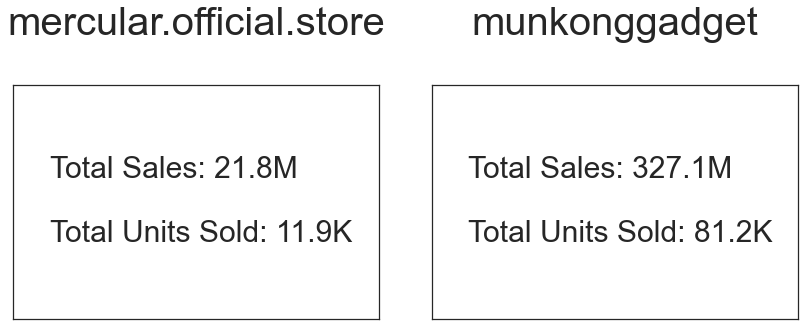

In [68]:
fig_total = plt.figure(figsize=(12,5))
for i,shp in enumerate(sorted(df_shp['shop_name'].unique())):
    _df = df_shp[df_shp['shop_name']==shp]
    ax_i = plt.subplot(121+i)
    txt = ""
    txt += f"Total Sales: {format_number(_df['sales'].sum())}"
    txt += f"\n\nTotal Units Sold: {format_number(_df['units_sold'].sum())}"
    plt.text(0.1,0.5,txt, verticalalignment='center', horizontalalignment='left', fontsize=30)
    ax_i.set_xticks([])
    ax_i.set_yticks([])
    ax_i.set_title(f'{shp}\n', fontsize=40)
plt.tight_layout(pad=2)
plt.savefig('./jpeg/total_sales.jpeg')

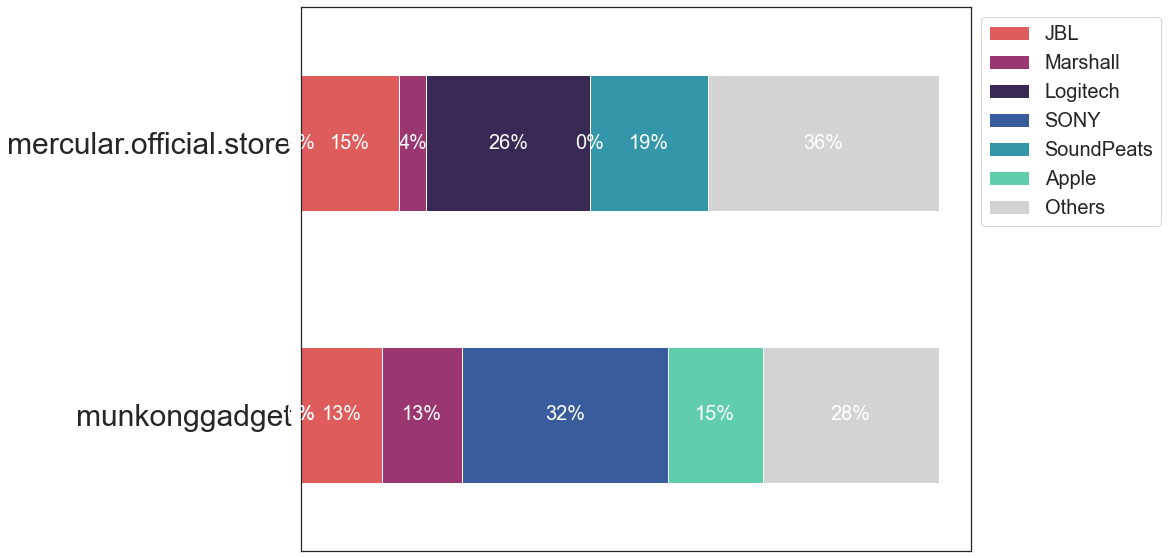

In [69]:
# agg
df_shp_brand = df_shp.groupby(['shop_name','brand'])[['sales','units_sold']].sum().reset_index()
# grouping Others
df_shp_brand['pcnt_sales'] = df_shp_brand['sales'] / df_shp_brand.groupby('shop_name')['sales'].transform('sum')
df_shp_brand['max_pcnt_sales'] = df_shp_brand.groupby('brand')['pcnt_sales'].transform('max')
df_shp_brand.loc[df_shp_brand['max_pcnt_sales'] < 0.1, 'brand'] = 'Others'
df_shp_brand = df_shp_brand.groupby(['shop_name','brand'])[['sales','units_sold','pcnt_sales']].sum().reset_index()
df_shp_brand['avg_price'] = df_shp_brand['sales'] / df_shp_brand['units_sold']

# columns
cnt = df_shp_brand[df_shp_brand['pcnt_sales'] > 0.02].groupby('brand')['shop_name'].count()
shop_names = df_shp_brand['shop_name'].unique()
brands = df_shp_brand['brand'].unique()
brands_1 = [x for x in cnt[cnt > 1].index if x != 'Others']
brands_2 = [x for x in brands if x not in brands_1 and x != 'Others']
# colors
colors1 = sns.color_palette("flare", n_colors=len(brands_1))
colors2 = sns.color_palette("mako", n_colors=len(brands_2))
colors = [*colors1, *colors2, 'lightgrey']
# format table
df_shp_brand_pivot = df_shp_brand.pivot_table(index='shop_name',
                                       columns='brand',
                                       values='pcnt_sales').fillna(0)
df_shp_brand_pivot = df_shp_brand_pivot[[*brands_1, *brands_2, 'Others']].sort_index(ascending=False)
# plot
fig_brand, ax = plt.subplots(figsize=(12,10))
df_shp_brand_pivot.plot.barh(stacked=True, color=colors, ax=ax)
# annotation
for c in ax.containers:
    ax.bar_label(c, label_type='center', fmt='{:.0%}', color='white', fontsize=20)
plt.yticks(fontsize=30)
ax.set_ylabel('')
ax.set_xticks([])
plt.legend(bbox_to_anchor=(1,1), fontsize=20)
plt.show()

In [70]:
df_shp[df_shp['item_name'].str.contains('AirPod')]

,item_name,price,items_sold,page,shop_name,scrapped_date,item_split,brand,units_sold,sales
1248,TPU Case for AirPods Pro TPU,199,ขายแล้ว 414 ชิ้น,2,munkonggadget,2023-10-10,"[TPU, Case, for, AirPods, Pro, TPU]",TPU Case for,414.0,82386.0
1303,Apple AirPods with Charging Case,4990,ขายแล้ว 3.8พัน ชิ้น,4,munkonggadget,2023-10-10,"[Apple, AirPods, with, Charging, Case]",Apple,3800.0,18962000.0


In [71]:
df_shp_brand['grand_avg_price'] = df_shp_brand.groupby('brand')['avg_price'].transform('mean')

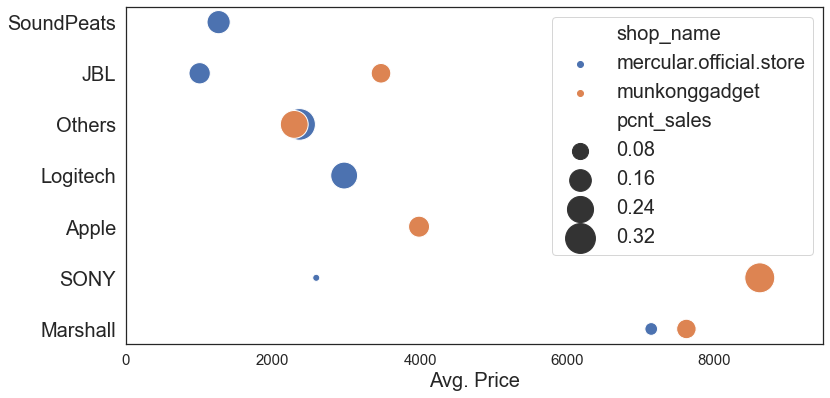

In [72]:
fig_brand, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(x='avg_price',
                y='brand', 
                hue='shop_name', 
                size='pcnt_sales',
                sizes=(50,1000),
                data=df_shp_brand.sort_values('grand_avg_price'))
ax.set_xlim(0, df_shp_brand['avg_price'].max()*1.1)
plt.legend(bbox_to_anchor=(1,1), fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=15)
ax.set_ylabel('')
ax.set_xlabel('Avg. Price', fontsize=20)
# ax.set_title('Price Comparison', fontsize=30)
plt.tight_layout(pad=2)
plt.show()

## Trending items

In [73]:
df_shp_last_wk = df_shp_raw.copy()
df_shp_last_wk['pcnt_sales'] = df_shp_last_wk['sales'] / df_shp_last_wk.groupby('shop_name')['sales'].transform('sum')
# drop duplicate
index = ['shop_name','item_name','scrapped_date']
df_shp_last_wk['rank'] = df_shp_last_wk.groupby(index)['units_sold'].rank(ascending=False, method='first')
# df_shp_last_wk = df_shp_last_wk[df_shp_last_wk['rank']==1].drop('rank', 1)
# weekly sales
index = ['shop_name','brand','item_name','rank']
df_shp_last_wk = df_shp_last_wk.sort_values([*index,'scrapped_date'])
for x in ['units_sold','sales','scrapped_date','price']:
    df_shp_last_wk[f'lag_{x}'] = df_shp_last_wk.groupby(index)[x].shift()
df_shp_last_wk['days'] = (df_shp_last_wk['scrapped_date'] - df_shp_last_wk['lag_scrapped_date']).dt.days
df_shp_last_wk = df_shp_last_wk[df_shp_last_wk['scrapped_date']==df_shp_last_wk['scrapped_date'].max()]
df_shp_last_wk['units_sold_last_week'] = (df_shp_last_wk['units_sold']-df_shp_last_wk['lag_units_sold']) / df_shp_last_wk['days'] * 7
df_shp_last_wk['sales_last_week'] = df_shp_last_wk['price'] * df_shp_last_wk['units_sold_last_week']
df_shp_last_wk['pcnt_sales_last_week'] = df_shp_last_wk['sales_last_week'] / df_shp_last_wk.groupby('shop_name')['sales_last_week'].transform('sum')

In [74]:
df_shp_last_wk_agg = df_shp_last_wk.groupby(['shop_name','brand'])[['pcnt_sales','pcnt_sales_last_week']].sum()
df_shp_last_wk_agg['sales_last_week_rank'] = df_shp_last_wk_agg.groupby('shop_name')['pcnt_sales_last_week'].rank(ascending=False)
df_shp_last_wk_agg['sales_rank'] = df_shp_last_wk_agg.groupby('shop_name')['pcnt_sales'].rank(ascending=False)
cond1 = df_shp_last_wk_agg['sales_last_week_rank'] <= 5
cond2 = df_shp_last_wk_agg['sales_rank'] <= 5
df_shp_last_wk_agg = df_shp_last_wk_agg[cond1|cond2]
df_shp_last_wk_agg = df_shp_last_wk_agg.reset_index()
df_shp_last_wk_agg['rank'] = df_shp_last_wk_agg['pcnt_sales_last_week'].rank(ascending=False)
df_shp_last_wk_agg = df_shp_last_wk_agg.melt(id_vars=['rank','shop_name','brand'],
                                            value_vars=['pcnt_sales','pcnt_sales_last_week'])
df_shp_last_wk_agg = df_shp_last_wk_agg.sort_values(['rank','variable'])
df_shp_last_wk_agg

,rank,shop_name,brand,variable,value
15,1.0,munkonggadget,SONY,pcnt_sales,0.150674
31,1.0,munkonggadget,SONY,pcnt_sales_last_week,0.625980
2,2.0,mercular.official.store,IPASON,pcnt_sales,0.001131
18,2.0,mercular.official.store,IPASON,pcnt_sales_last_week,0.123489
7,3.0,mercular.official.store,Marshall,pcnt_sales,0.013504
23,3.0,mercular.official.store,Marshall,pcnt_sales_last_week,0.122791
5,4.0,mercular.official.store,Klipsch,pcnt_sales,0.007201
21,4.0,mercular.official.store,Klipsch,pcnt_sales_last_week,0.075187
0,5.0,mercular.official.store,Creative,pcnt_sales,0.016424
16,5.0,mercular.official.store,Creative,pcnt_sales_last_week,0.065169


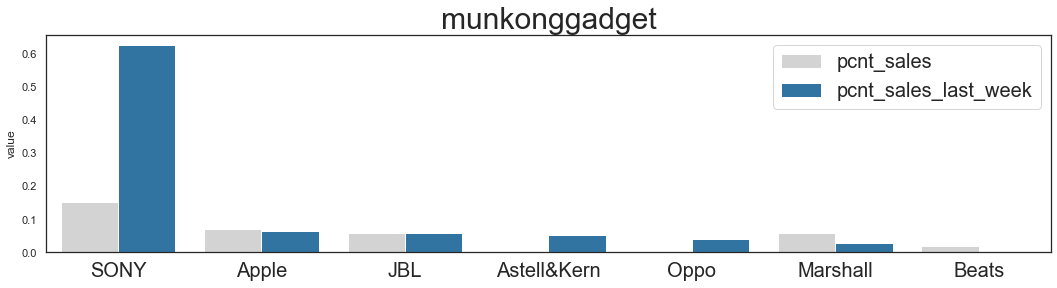

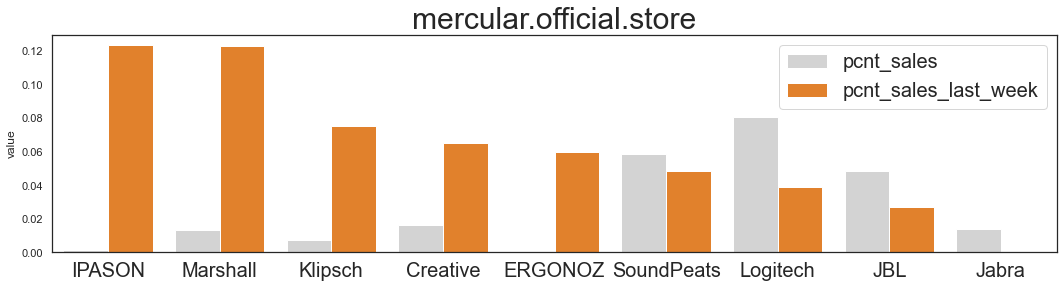

In [75]:
colors = ['tab:blue','tab:orange']
for c,shp in zip(colors,df_shp_last_wk_agg['shop_name'].unique()):
    _df = df_shp_last_wk_agg[df_shp_last_wk_agg['shop_name']==shp]
    plt.figure(figsize=(18,4))
    sns.barplot(x='brand', y='value', hue='variable', 
                palette=('lightgrey',c),
                data=_df)
    plt.title(shp, fontsize=30)
    plt.xticks(fontsize=20)
    plt.xlabel('')
#     plt.ylim(0,1)
    plt.legend(fontsize=20)
    plt.show()

# Youtube and Shopee

In [76]:
# Youtube items
df_ytb_item = df_ytb.copy()
df_ytb_item = df_ytb_item[df_ytb_item['years_posted'] <= 1]
df_ytb_item = df_ytb_item.groupby(['channel','brand','item_name'])['views'].sum().reset_index()
df_ytb_item['max_views'] = df_ytb_item.groupby('channel')['views'].transform('max')
cond = df_ytb_item['views'] >= 0.1*df_ytb_item['max_views']
df_ytb_item = df_ytb_item[cond]
df_ytb_item['name_only'] = df_ytb_item.apply(lambda x: x['item_name'].replace(x['brand'],'').strip(),1)
df_ytb_item['first_word'] = df_ytb_item['name_only'].str.split(' ').apply(lambda x: x[0])
df_ytb_item['join'] = df_ytb_item['brand'].str.lower()+df_ytb_item['first_word'].str.lower()
df_ytb_item = df_ytb_item.drop(['name_only','first_word','max_views'], 1)
df_ytb_item = df_ytb_item.sort_values('views', ascending=False)

# Shopee items
df_shp_item = df_shp.copy()
df_shp_item['name_only'] = df_shp_item.apply(lambda x: x['item_name'].replace(x['brand'],'').strip(),1)
df_shp_item['first_word'] = df_shp_item['name_only'].str.split(' ').apply(lambda x: x[0])
df_shp_item['join'] = df_shp_item['brand'].str.lower()+df_shp_item['first_word'].str.lower()
df_shp_item = df_shp_item[['shop_name','brand','item_name','join','sales','units_sold']]

# Map youtube and shopee
df_map = df_ytb_item.merge(df_shp_item, 
            on=['brand','join'],
            how='left', 
            suffixes=('_youtube','_shopee'))
df_map['sales (M)'] = df_map['sales'] / 10**6

<ipython-input-76-e4d0725b41e4>:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_ytb_item = df_ytb_item.drop(['name_only','first_word','max_views'], 1)


Text(0.5, 1.0, 'Views on item reviewing videos\n')

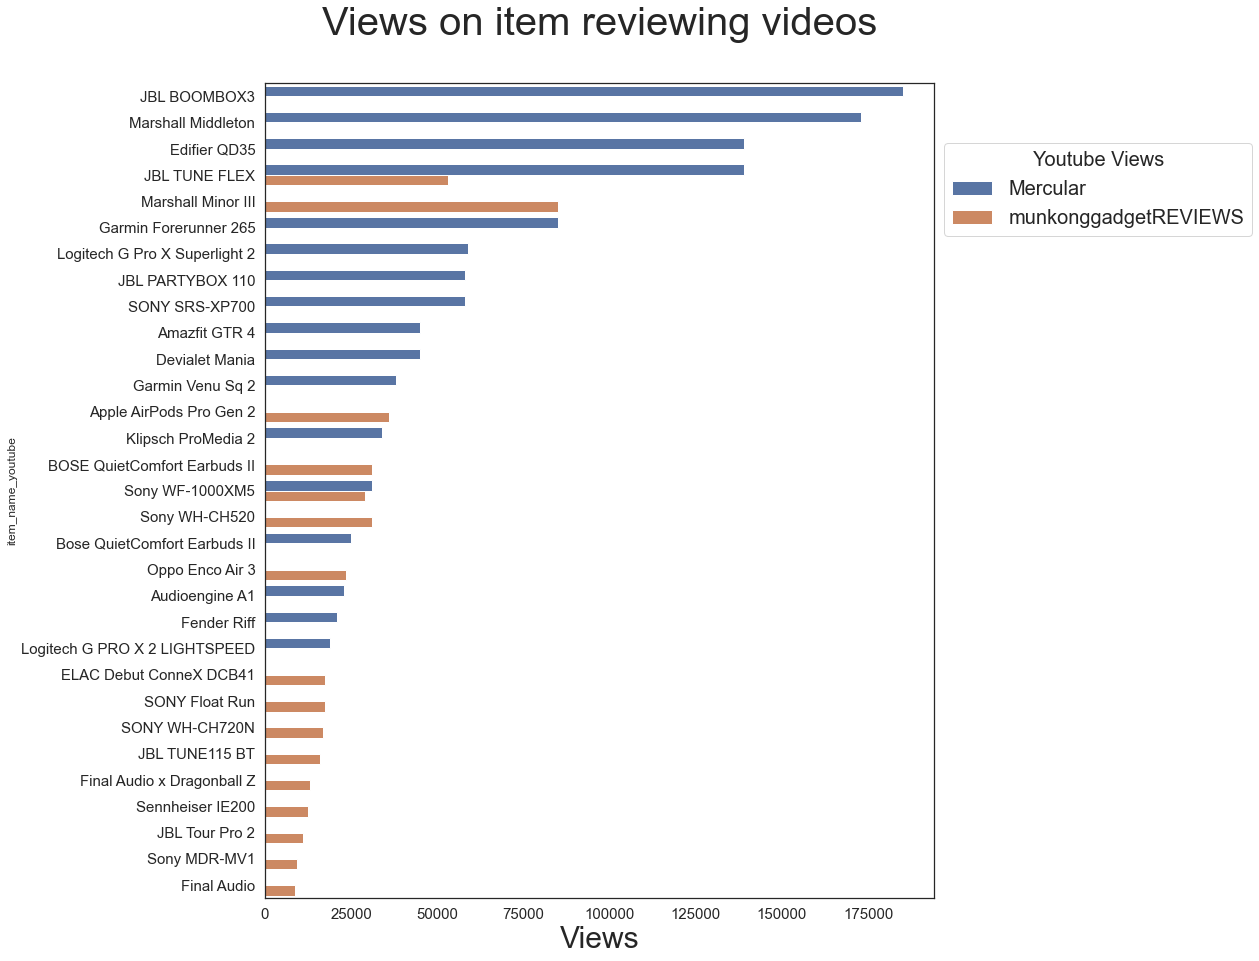

In [85]:
figure, ax = plt.subplots(figsize=(12,15))
sns.barplot(x='views', 
            y='item_name_youtube', 
            hue='channel', 
            data=df_map, 
            ax=ax)
plt.legend(bbox_to_anchor=(1,0.8), title='Youtube Views', fontsize=20, title_fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlabel('Views', fontsize=30)
plt.title("Views on item reviewing videos\n", fontsize=40)

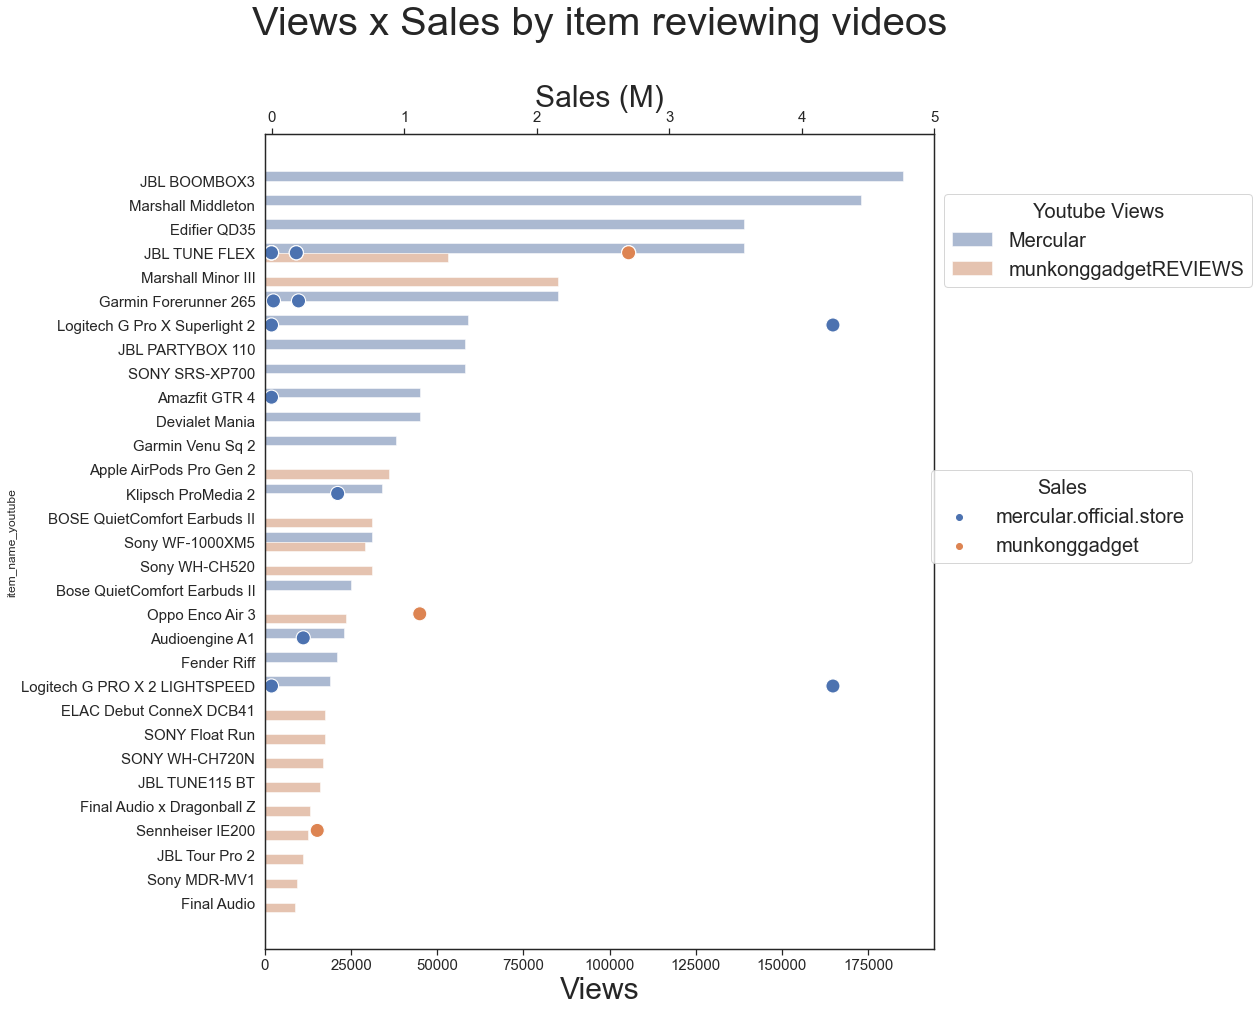

In [91]:
# Views
figure, ax = plt.subplots(figsize=(12,15))
sns.barplot(x='views', 
            y='item_name_youtube',
            hue='channel', 
            data=df_map,
            ax=ax, 
            alpha=0.5)
plt.legend(bbox_to_anchor=(1,0.8), title='Youtube Views', fontsize=20, title_fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlabel('Views', fontsize=30)

# Sales
ax2 = ax.twiny()
sns.scatterplot(x='sales (M)',
                y='item_name_youtube', 
                hue='shop_name', 
                hue_order=('mercular.official.store', 'munkonggadget'),
                s=200,
                data=df_map)
ax2.set_xlim(-0.05,5)
ax2.set_xlabel('Sales (M)', fontsize=30)
plt.xticks(fontsize=15)
plt.legend(bbox_to_anchor=(1.4,0.6), title='Sales', fontsize=20, title_fontsize=20)
plt.title("Views x Sales by item reviewing videos\n", fontsize=40)

plt.show()